<a href="https://colab.research.google.com/github/savitha91/AudioSignal_Analysis/blob/master/AudioAnalysis_FeatureExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Audio signal analysis**

Main purpose of the notebook is to explain about audio signals and steps involved in extracting audio features from audio file. 

1. Audio signals are time-series(periodic) signals, which can 
be examined in 2 domain - Time domain and Frequency domain
2. Human ears act as a set of filter, which concentrate on certain frequencies. Aim is to extract  significant features from the frequencies which humans can hear.


## **Dataset**
Video file(.mp4) from MELD dataset







In [ ]:
!pip install ffmpeg
! pip install librosa

In [1]:
import numpy as np
import librosa
import librosa.display
import moviepy.editor 
import os
import matplotlib.pyplot as plt
import scipy

In [2]:
BASE_PATH = '/content'
VIDEO_FILENAME = 'dia1_utt0.mp4'
utterance = "Or! Or, we could go to the bank, close our accounts and cut them off at the source."

# **Sampling rate**
*   Sampling rate is the frequency at which the audio signals are captured
*   Sampling rate = 44100 means, 44100 samples are captured in a second.
*   Sampling rate depends on the file format


In [3]:
sample_rate = 44100

**Video file(.mp4) is the input. Here, we convert the video file to audio file(.mp3)** 

In [4]:
def convertVideoToAudio(videoFile):
    audio_file_path = BASE_PATH + '/' + videoFile.split('.')[0] + '.mp3'
    if os.path.exists(audio_file_path):
        print(audio_file_path," EXISTS!")
    else:
        print("Converting to", audio_file_path)
        video = moviepy.editor.VideoFileClip(BASE_PATH +'/'+ videoFile)
        audio = video.audio
        try:
            audio.write_audiofile(audio_file_path)
        except Exception as e:
            print("LOG :: Failed to create audio file")
    return audio_file_path

audio_file_path = convertVideoToAudio(VIDEO_FILENAME)

Converting to /content/dia1_utt0.mp3
[MoviePy] Writing audio in /content/dia1_utt0.mp3


100%|██████████| 139/139 [00:00<00:00, 762.93it/s]


[MoviePy] Done.


**Audio files have the information like total number of samples, audio duration etc. Here, we extract these informations using librosa** 

In [5]:
def loadAudioFile(audioFile):
    print(" ")
    print("*** LOADING FILE ***", audioFile)
    samples,_= librosa.load(audioFile, sr=sample_rate)
    print("Total number of samples in the audio file", len(samples))
    print("Audio signal is sampled at", sample_rate,"freq")
    print("Duration of the audio ", np.round(samples.shape[0]/sample_rate , 3),"seconds")
    return samples

samples = loadAudioFile(audio_file_path)

 
*** LOADING FILE *** /content/dia1_utt0.mp3
Total number of samples in the audio file 276948
Audio signal is sampled at 44100 freq
Duration of the audio  6.28 seconds


# Apply Pre-emphasis filter to amplify the high frequencies. 


A pre-emphasis filter is useful in several ways: 
1. balance the frequency spectrum since high frequencies usually have smaller magnitudes compared to lower frequencies, 
2. avoid numerical problems during the Fourier transform operation
3. improve the Signal-to-Noise Ratio (SNR).

In [6]:
def applyPreEmphasisFilter(pre_emphasis):
  return np.append(samples[0], samples[1:] - pre_emphasis * samples[:-1])

emphasized_signal = applyPreEmphasisFilter(pre_emphasis = 0.97)

In [7]:
def normalize_audio(samples):
    samples = samples / np.max(np.abs(samples))
    return samples

samples = normalize_audio(emphasized_signal)

# **Time domain analysis**
*   Amplitude as a function of Time 
*   Loudness of the sound in one second time period is measured
* Retains sequential order of the audio signal





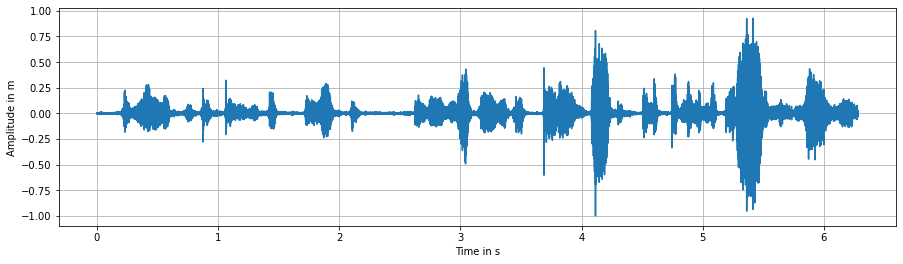

In [8]:
def plotTimeDomain(samples):
    plt.figure(figsize=(15,4))
    plt.plot(np.arange(0, samples.shape[0]/sample_rate, 1/sample_rate), samples)
    plt.xlabel('Time in s')
    plt.ylabel('Amplitude in m')
    plt.grid(True)

plotTimeDomain(samples) 

# Inference on Time-domain graph


Here, we see the audio waves for our entire audio duration(6.28s). Places where amplitude ~ 0, can be interpreted as no-voiced regions. Places where amplitude is > 0 are the voiced regions




# **Frequency domain analysis**


*  Amplitude as a function of frequency 
*  We measure how strong is the signal(amplitude) at all the frequencies
*  To convert signal from Time-domain to frequency domain, Fourier transform is applied
* Sequential order of the signal is ignored(as the time component is not available)



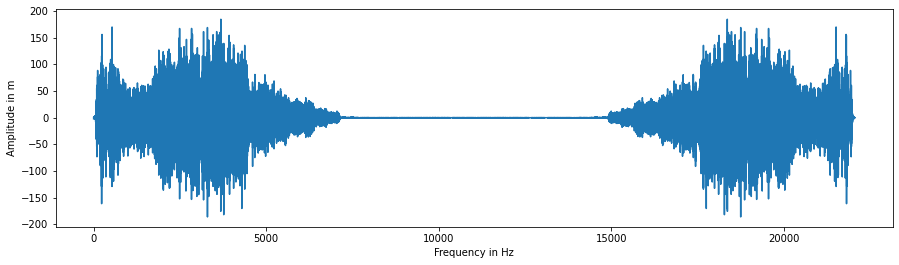

In [9]:
def plotFrequencyDomain(samples):
    n = len(samples)
    yf = scipy.fft(samples)
    xf = np.linspace(0.0, sample_rate/2 , n) # Nyquist theorem
    plt.figure(figsize=(15,4))
    plt.xlabel("Frequency in Hz")
    plt.ylabel("Amplitude in m")
    plt.plot(xf, yf[:n])

plotFrequencyDomain(samples) 

# Inference on Frequency-domain graph
* PEAKS a.k.a Formants convey dominant frequency components in the speech signal
* Peak at ~5Hz in frequency domain, indicates there are 5 cycles per second in the Time domain
* Peak at higher frequency range indicates, there are more cycles/sec, i.e more fluctuating signals
* Here, we see peaks in the lower frequency range(0 to 1000Hz and 2kHz to 4KHz) and higher frequency range(22KHz to 24KHz). This tells that the audio clip has human speech
* Here, we lost time info, hence, we donot know the order in which words were spoken. 

# **Spectrogram**
* Frequency(y-axis) as a function of Time(x-axis)
* Spectrogram is a sequence of spectral vectors represented using grey level values
* Spectrogram represents energy level of each frequency over the duration of audio
* Internally, the signals are broken into smaller overlapping chunks and Fourier transform is applied on each chunk



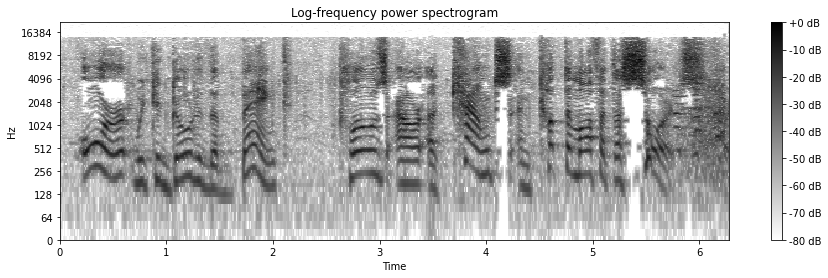

In [10]:
def plotSpectogram(samples):
    D = librosa.amplitude_to_db(librosa.stft(samples), ref=np.max)
    plt.figure(figsize=(15, 4))
    librosa.display.specshow(D,sr=44100,cmap='gray_r',x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log-frequency power spectrogram')
    plt.show()

plotSpectogram(samples)

# Inference on Spectrogram graph


1. Dark grey(black) indicates Peak(Formant) i.e voice signal and White indicates NonPeak region i.e non-voiced or silence , which means amplitude(Energy) of the signal is almost zero
2. We can see white region between 3.1s and 3.2s, this indicates that amplitude at that region is almost zero, which can be verified against Time-domain graph
3. At 0.5s, we can see dark region/peak at 256Hz i.e 256 cycles per second which indicates that we have voiced data , which can be verified against Time-domain graph



# **Extract features from audio signal**

* Audio signal is a Time-series signal, hence, we can break the signal at certain constant time-steps. 
* Optimum window duration(window_ms) is 20-30ms, as humans cannot utter more than one phoneme in this span.For Speech-recognition, we consider window overlap(stride),in order to avoid information loss as 50% (stride_ms = 10ms)
* The entire audio(6.28s) is split at 20ms interval with overlap between the windows(stride) at 10ms
* Windows and strides(overlap) in audio signal is same  as filters and strides in CNN
* Number of samples in each window and overlap regions are calculated using 
      * stride_size = int(0.001 * sample_rate * stride_ms) 
      * window_size = int(0.001 * sample_rate * window_ms)


# Steps involved in feature extraction 
1. Break the audio signal into overlapping frames
2. Apply windowing function(Hanning) to enhance the ability of  FFT to extract spectral data from signals
3. Apply Fourier transform to get the frequency domain (Spectrum)
4.Perform Cepstral Analysis - This is achieved in 2 steps 
* a. Conversion of the Fourier coefficients to Mel-scale - which results in Mel spectrum
* b. Decorrelate logarithimized filter-bank coefficients by applying Discrete Cosine Transform(DCT) - which results in Mel-Frequency Cepstral Coefficients denoted by *MFCC*



In [11]:
stride_ms = 10.0
window_ms = 20.0 
stride_size = int(0.001 * sample_rate * stride_ms)
window_size = int(0.001 * sample_rate * window_ms)

# **1. Break the audio signal into overlapping frames**

# Purpose
Frequencies in a audio signal change over time. When we take Fourier transform(FT) across the entire signal,we would lose the frequency contours of the signal over time. To avoid that, we break the signal into smaller frames, take FT over the time-frames(assuming frequencies  are stationary over a very short period of time) and finally obtain the frequency contours of the signal by concatenating adjacent frames.


# Technique
Here, we break the entire audio signal(in our case 6.28s) into multiple overlapping frames by applying window and strides. The amount by which the filter shifts is the stride. In case of audio signals, we shift by certain number of bytes. This is calculated using in-build method stride_tricks.as_strided. 





In [12]:
def breakAudioIntoChunks(samples):
    total_windows_in_audio = int((len(samples) - window_size) / stride_size) + 1
    # Pad Signal so that all the frames have equal number of samples without truncating any sample from the original signal
    pad_signal_length = total_windows_in_audio * stride_size + window_size
    pad_width = pad_signal_length - len(samples)
    padded_signal = np.pad(samples,pad_width,mode='reflect')
    print(len(padded_signal))
    totalFrames_afterPadding = int((len(padded_signal) - window_size) / stride_size) + 1
    print("Total number of windows(frames) in the audio of duration",np.round(padded_signal.shape[0]/sample_rate , 3), " is ", totalFrames_afterPadding)   
    print("1st window starts at 0th sample upto", window_size, "samples. 2nd window starts at sample number", stride_size, "upto",stride_size+window_size)
    skip_bytes_stride = padded_signal.strides[0]
    nshape = (totalFrames_afterPadding,window_size)
    skip_bytes_in_audio = stride_size * skip_bytes_stride
    print("We have to skip", skip_bytes_in_audio, "bytes (i.e stride stepsize) to move to start the next window")
    audioFrames = np.lib.stride_tricks.as_strided(padded_signal, shape=nshape, strides=(skip_bytes_in_audio,skip_bytes_stride))
    print("Window shape : " ,audioFrames.shape)
    print("i.e, there are total ", nshape[0], "timeframes/windows in the given audio, with each timeframe containing ", window_size," samples")
    return audioFrames


audioFrames = breakAudioIntoChunks(samples)

277830
Total number of windows(frames) in the audio of duration 6.3  is  629
1st window starts at 0th sample upto 882 samples. 2nd window starts at sample number 441 upto 1323
We have to skip 1764 bytes (i.e stride stepsize) to move to start the next window
Window shape :  (629, 882)
i.e, there are total  629 timeframes/windows in the given audio, with each timeframe containing  882  samples


# Result Inference 
From the results we can see that there are 629 frames (windows), where each frame has 882 samples

# **2. Apply window functions**

Before applying FFT, we apply windowing function like “Hamming/Hanning/Kaiser” to enhance the ability of  FFT to extract spectral data from signals(amplitude accuracy) , reduce the noise(side lobes), counteract the assumption made by the FFT that the data is infinite and eliminate discontinuity in the wave. Here we apply Hanning window function


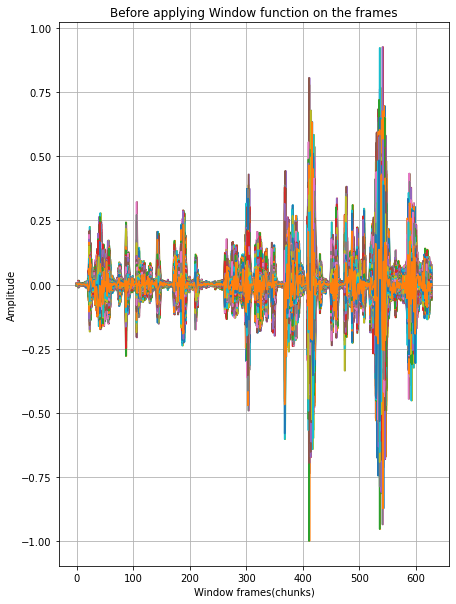

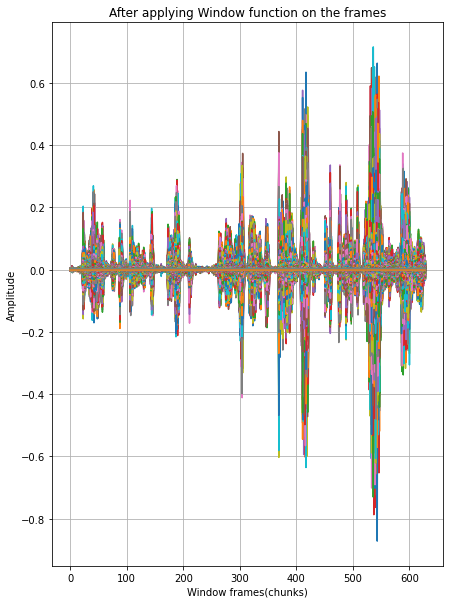

In [13]:
def applyWindowingFunction(audioFrames):
    plt.figure(figsize=(7,10))
    plt.title("Before applying Window function on the frames")
    plt.xlabel("Window frames(chunks)")
    plt.ylabel("Amplitude")
    plt.plot(audioFrames)
    plt.grid()
    # Apply Hanning window function on the window frames
    hanWeights = np.hanning(window_size) 
    weighed_AudioFrames = audioFrames * hanWeights
    plt.figure(figsize=(7,10))
    plt.title("After applying Window function on the frames")
    plt.xlabel("Window frames(chunks)")
    plt.ylabel("Amplitude")
    plt.plot(weighed_AudioFrames)
    plt.grid()
    return weighed_AudioFrames


weighed_AudioFrames = applyWindowingFunction(audioFrames)


# Result Inference
The function displays two graphs. First graph shows the audio signals in the entire 629 windows before applying the hanning window function. Second graph shows the audio signal after applying Hanning window function. We can see from the second graph that the noise(side-lobes) is reduced, amplitude accuracy is enhanced and discontinuity in the wave is eliminated to some extent

# **3. Apply Fourier Transform**

To convert audio signal from time domain to frequency domain(Spectrum), we apply Fourier transform on each audio frame(window)

# Why use Fast Fourier transform(FFT) in audio processing

FFT converts a signal into individual spectral components and thereby provides frequency information about the signal.

Output shape (629, 882)


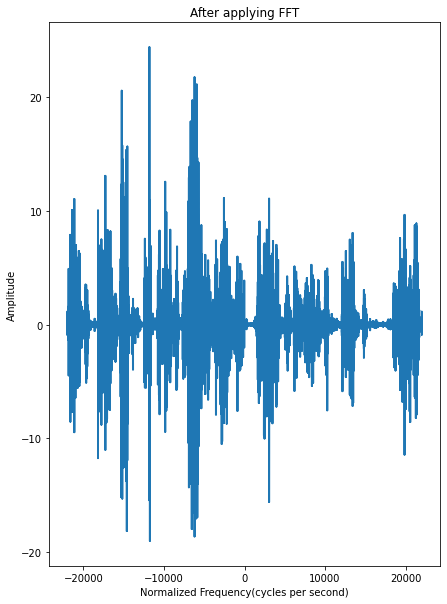

In [14]:
def applyFFT_plotSpectrum(weighed_AudioFrames): 
    n = len(weighed_AudioFrames)
    T = 1.0/sample_rate
    yf = np.fft.fft(weighed_AudioFrames)
    xf = np.fft.fftfreq(yf.size, d=T)
    plt.figure(figsize=(7,10))
    plt.title("After applying FFT")
    plt.xlabel("Normalized Frequency(cycles per second)")
    plt.ylabel("Amplitude")
    plt.plot(xf, yf.flatten())
    print("Output shape",yf.shape)
    plt.show()
    
applyFFT_plotSpectrum(weighed_AudioFrames)

# Result Inference
We get the Spectrum i.e Amplitude as a function of Frequency. Here, the time component of the signal is lost. Result obtained on applying Fourier transform on the audio frames (yf) is a sequence of spectral vectors. For better understanding of the signal, these spectral vectors cane be represented using grey level values, which provides **Spectrogram** (discussed above) 

## Apply rfft on the frames, which computes only the non-negative(positive) frequency terms



In [15]:
def apply_rfft(weighed_AudioFrames):
    mag_frames = np.fft.rfft(weighed_AudioFrames)
    mag_frames = np.absolute(mag_frames) 
    audio_power = np.square(mag_frames)
    print("Output shape",audio_power.shape)
    return audio_power

audio_power = apply_rfft(weighed_AudioFrames)

Output shape (629, 442)


## Result Inference
This function is similar to the above function, which gives us the sequence of spectral vectors/components (i.e spectrum). You can find the difference in the output shape.

1. When we applied FFT, the output shape = (629,882) i.e (Total_frames , TotalSamples_InEachFrame), which means FFT applied on entire wave
2. When we applied rfft, the output shape = (629,442) i.e (Total_frames , (TotalSamples_InEachFrame/2)+1), which means rfft applied on the positive part of the wave


# **4. Perform Cepstral Analysis - Compute MFCCs**

1. Aim of cepstral analysis is to separate spectral envelope and spectral details
2. We have log mel-spectrum. Applying IFFT (Cepstral analysis) on the log mel-spectrum  gives Cepstrum. In our case, it is **Mel frequency Cepstrum**  
*   log X[k] = log H[k] + log E[k]
*   IFFT on log X[k] gives x[k] = h[k] + e[k], where , x[k] is the Mel-frequency Cepstrum
3. Mel-frequency Cepstrum provides signals in the high and low frequency regions. The low-frequency region of Cepstrum provides Cepstral coefficients (of spectral envelope)
4. Cepstral coefficients h[k] obtained for Mel- spectrum are referred to as Mel-Frequency Cepstral Coefficients often denoted by *MFCC*

# Mel frequency Cepstrum 
Mel frequency Cepstrum is the representation of short-term power spectrum of a sound, based on a linear discrete cosine transform(DCT) of a log power spectrum on a nonlinear mel scale of frequency. [wiki]

# MFFC computation
Computation of MFCCs includes
* **4a. Conversion of the Fourier coefficients to Mel-scale.**After conversion, the obtained vectors(Filter-bank coefficients) are logarithmized.
* **4b. Decorrelate logarithimized filter-bank coefficients 
by applying Discrete Cosine Transform(DCT)** to remove redundant information. The components of MFCCs are the first few DCT coefficients that describe the spectral shape.




# **4a. Conversion of Fourier coefficients to Mel-scale**

This step involves computing Mel-spaced filterbank(20-40 triangular filters, 26 being the standard) that are applied to the power spectrum , which results in Mel Spectrum

Human ears concentrate on certain frequencies, rather than the entire spectrum. Mel filterbank is used to simulate the "filterbank" in human ears. We apply triangular mel filters(non-uniformly distributed - more filters in the low-frequency regions, and less number of filters in the high-frequency regions ) on the spectrum. n_mels specify the number of filters, which are applied on mel-scale.The Mel-scale aims to mimic the non-linear human ear perception of sound, by being more discriminative at lower frequencies and less discriminative at higher frequencies. Applying the mel-filters on the spectrum gives the Mel-Spectrum, where the frequency scale is changed from Hertz(f) and Mel(m).Finally,take log on the mel-spectrum

Spectrum -> Mel-Filters -> Mel-Spectrum

# Mel Spectrum 
1. Mel Spectrum  is a combination of Spectral Envelope and Spectral 
details
log X[k] = log H[k] + log E[k] , where log 
2. Spectral Envelope is the smooth curve connecting the dominant(significant) frequency component(FORMANT)
3. Spectral details is the remaining noise signal

In [16]:
n_mels = 26

def performCepstralAnalysis(audio_power,n_mels):
    #initialise the mel filter
    filter_banks = librosa.filters.mel(sr=sample_rate, n_fft=window_size, n_mels=n_mels)
    #Applying mel filters on our spectrum. This gives us mel-Spectrum
    audio_filtered = filter_banks.dot(np.transpose(audio_power))
    #Taking log on the mel-spectrum
    audio_filtered = librosa.power_to_db(audio_filtered, ref=np.max)
    print("Shape of filter bank coefficients", audio_filtered.shape)
    return audio_filtered

audio_filtered = performCepstralAnalysis(audio_power,n_mels)

Shape of filter bank coefficients (26, 629)


# Result Inference
26 Mel filter banks(n_mels) are applied on the spectrum, which results in the array (26,629).Here, 26 in the result represents Filter-bank coefficients in 629 frames. 

# **4b.Decorrelate logarithimized filter-bank coefficients by applying DCT**

The logarithimized filter-bank coefficients obtained in previous step are highly correlated, which could be problematic in some machine learning algorithms. Hence, we apply Discrete Cosine Transform(DCT, also know as whitening process) to decorrelate the filter bank coefficients and yield a compressed representation of the filter banks. DCT applied on the log filterbank coefficients gives Cepstral coefficents (a.k.a MFCCs). In Automatic Speech Recognition(ASR), 2-13 coefficients are retained and rest are discarded, as they represent fast changes in the coefficients and donot contribute to the ASR. 

For example,
* 1st coefficient represents average power in the spectrum
* 2nd coefficient represents spectral centroid
* 8-13th coefficients represent spectral envelope/ shape of the signal
* 19th coefficient represents pitch or spectral details

dct_filter_num represents number of coefficients to be retained


In [17]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)  
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)
    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)        
    return basis

In [18]:
dct_filter_num = 12

def getMFCC_manually(audio_filtered, n_mels, dct_filter_num):
    dct_filters = dct(dct_filter_num, n_mels)
    mfcc = np.dot(dct_filters, audio_filtered)
    print("Shape of cepstral coefficients",mfcc.shape)
    print("1st mel cepstral coefficient in the first 10 frames : ",mfcc[0][:10])
    return mfcc

mfccs_manual = getMFCC_manually(audio_filtered, n_mels, dct_filter_num)

Shape of cepstral coefficients (12, 629)
1st mel cepstral coefficient in the first 10 frames :  [-259.78174146 -262.52163788 -259.43906916 -243.68913697 -245.31830315
 -253.44704868 -262.44196345 -264.40556624 -270.37716061 -266.51066179]


# Result Inference
Here, we obtain 12 mel frequency cepstral coefficients.
The shape (12,629) means, in all the 629 frames(a.k.a, time-steps), we obtain 12 coefficients(mfccs). Each coefficient(mfcc) is represented as vector of size 629 (=frames), i.e 1st coefficient in all the 629 windows are available in mfcc[0]

We pass these 12 mfccs as input to the speech recognition(SR) model(eg. seq2seq model). 

NOTE: Before we pass the vector to SR mode, we need to reshape it into 629 time steps, with each step containing 12 mel spectral coefficients(mfccs) i.e shape of the input vector should be (629,12)


# Extract MFCC from audio - End2End

All the steps mentioned above are combined into a single method to extract mfcc

Note: uncomment the last line while executing

In [19]:
def extractMFCC():
  audioFrames = breakAudioIntoChunks(samples)
  weighed_AudioFrames = applyWindowingFunction(audioFrames)
  audio_power = apply_rfft(weighed_AudioFrames)
  audio_filtered = applyMelFilters_getMelSpectrum(audio_power,n_mels)
  mfccs = performCepstralAnalysis_getMFCCs(audio_filtered, n_mels, dct_filter_num)
  return mfccs_manual

# mfccs_manual = extractMFCC(samples)

# Extract MFCCs using librosa package

* We can extract the Mel frequency coefficients from audio signal in just 3 lines of code using librosa package.
* All the operations mentioned above are performed within the package
* First we calculate the filter bank coefficients using melspectrogram method with number of filter banks as 26
* Next, we apply log function on the filter bank coefficients
* Finally, we call the method mfcc, which internally applies Discrete Cosine Transform, resulting the 12 mfccs(specified by n_mfcc = 12)

In [20]:
n_mfcc = 12
n_mels = 26

def getMFCC_librosa(samples,n_mfcc,n_mels):
    S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_fft=window_size, hop_length=stride_size, n_mels=n_mels)
    S_DB = librosa.power_to_db(S, ref=np.max)
    mfcc_librosa = librosa.feature.mfcc(S=S_DB, n_mfcc=n_mfcc)
    print("Shape of Cepstral coefficents",mfcc_librosa.shape)
    print("1st mel cepstral coefficient in the first 10 window frames : ",mfcc_librosa[0][:10])
    return mfcc_librosa

mfcc_librosa = getMFCC_librosa(samples,n_mfcc,n_mels)  

Shape of Cepstral coefficents (12, 629)
1st mel cepstral coefficient in the first 10 window frames :  [-259.78631448 -262.51626175 -259.44394921 -243.67898965 -245.31686952
 -253.44916922 -262.45722294 -264.41086542 -270.38173885 -266.51999076]


# Result Inference

The results obtained using librosa package is same as the results from getMFCC_manually() method

Here, we obtain 12 mel frequency cepstral coefficients. The shape (12,629) means, in all the 629 frames(a.k.a, time-steps), we obtain 12 coefficients(mfccs). Each coefficient(mfcc) is represented as vector of size 629 (=frames), i.e 1st coefficient in all the 629 windows are available in mfcc[0]

We pass these 12 mfccs as input to the speech recognition(SR) model(eg. seq2seq model).

NOTE: Before we pass the vector to SR mode, we need to reshape it into 629 time steps, with each step containing 12 mel spectral coefficients(mfccs) i.e shape of the input vector should be (629,12)

# References

* https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html#fn:1
* http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/
* https://stackoverflow.com/questions/40084931/taking-subarrays-from-numpy-array-with-given-stride-stepsize
* https://www.kaggle.com/ilyamich/mfcc-implementation-and-tutorial
* https://archive.org/details/SpectrogramCepstrumAndMel-frequency_636522

